# Part2: Emotions & Images in Tweets 
> Train a Classifier based on Emotion6 dataset

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/CNN.png

## Approach
Creating a Custom Convolutional Network


## Beyond the Text 
Beside the text, Twitter messages often include images, emojis or other special characters.
One approach to understand the overall sentiments from tweets is to work with each layer of information separately and then combining the analysis to reach a result that reflects all layers of the information.
This section will look at images separate from the text. Unpacking a way of analyzing images. 

## How to understand images?
We often understand a complex set of meaning from an image through a quick glance but what does it take for an automated system to understand the interplay of meaning in an image. There are multiple approaches in understanding an image. For instance, an image could be segregating into objects through image segmentation and using further meaning driven analysis a meaning of the image can be formed. 
But a holistic approach could prove beneficial too. Considering the multitude and complexities that are involved in making sense of images. The first approach here is use a pre-trained resnet model to identify emotions through images. 
The idea is that we could train a Machine Learning model with a set of images. After the initial training stage, the model should be able to identify the meaning of any new image that we get from tweets for instance.


## Project Goals
In this project, I’m looking to identify the overall reaction around a certain topic. One approach would be to identify tweets based on their underlying sentiment, such as anger, joy, sadness, etc. The first step is to find a dataset which includes images with their corresponding labels. This dataset can be used to train the initial model. 
Looking for such a dataset, I found [Emotion6] dataset from [Cornel University AMP lab] (http://chenlab.ece.cornell.edu/downloads.html).  Emotion6 is a collection of 1980 images and is divided into six categories of anger, disgust, fear, joy sadness, neutral .

## Citations
[1] Kuan-Chuan Peng, Amir Sadovnik, Andrew Gallagher, and Tsuhan Chen. "A Mixed Bag of Emotions: Model, Predict, and Transfer Emotion Distributions.", Computer Vision and Pattern Recognition (CVPR), 2015.

## Step 1- loading data into numpy array & Normalize it divide into test and training datasets
## Step 2 - Define the CNN
## Step 3 - define a loss function
## step 4 -  test the network on the test data

In [15]:
%matplotlib inline

In [16]:
import torch
import torchvision

import os
import numpy as np
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

import torch.nn.functional as F


import matplotlib.pyplot as plt

from torchvision import models



In [17]:
# from PIL import Image

In [18]:
#checking for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
device

device(type='cuda', index=0)

In [20]:
#Display some of the images from each category
# Image.open('/Data/Emotions6/Images').convert('RGB')


In [28]:
#Transforms -original
transformer = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #0-255 to 0-1, num py to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to 1- to 1
                         [0.5,0.5,0.5])
])

# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])


# training_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                           transforms.RandomResizedCrop(224),
#                                           transforms.RandomHorizontalFlip(),
#                                           transforms.ToTensor(),
#                                           transforms.Normalize([0.485, 0.456, 0.406], 
#                                                                [0.229, 0.224, 0.225])])

In [29]:
#Path for test and training data
test_path = 'Data/Emotion6/images/emot_test'
train_path = 'Data/Emotion6/images/emot_train'

batch_size= 10

#DataLoader
train_loader = DataLoader(
        torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size= 10, shuffle = True
)

test_loader = DataLoader(
        torchvision.datasets.ImageFolder(test_path,transform=transformer),
        batch_size= 10, shuffle = True
)

In [30]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [31]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [33]:
#categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [36]:
print(classes)

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


/tmp/ipykernel_3496/1155777525.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])


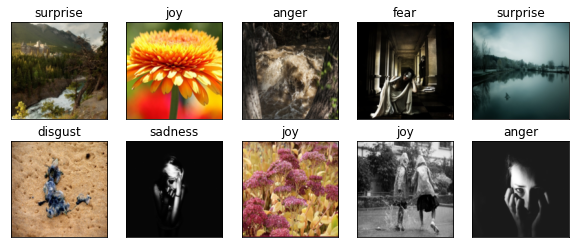

In [35]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [66]:
#CNN Network - original
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        
        self.pool=nn.MaxPool2d(kernel_size=2)        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
                
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
#         self.conv4=nn.Conv2d(in_channels=32,out_channels=46,kernel_size=3,stride=1,padding=1)        
#         self.bn4=nn.BatchNorm2d(num_features=46)        
#         self.relu4=nn.ReLU()
        
        
                
        self.fc=nn.Linear(in_features=75 * 75 * 32 ,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [67]:
model = ConvNet(num_classes=6).to(device)
# model = Net()
# model = models.vgg16(pretrained=True)
# model = models.vgg16(pretrained=True)


In [68]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [69]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [70]:
print(train_count,test_count)

1584 396


In [71]:
num_epochs=11

In [72]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #1-Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    #training loader loop
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    #2-Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_CNN1.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(17.3005) Train Accuracy: 0.20012626262626262 Test Accuracy: 0.23484848484848486
Epoch: 1 Train Loss: tensor(5.1706) Train Accuracy: 0.39330808080808083 Test Accuracy: 0.20707070707070707
Epoch: 2 Train Loss: tensor(1.8187) Train Accuracy: 0.5271464646464646 Test Accuracy: 0.22474747474747475
Epoch: 3 Train Loss: tensor(0.9630) Train Accuracy: 0.6830808080808081 Test Accuracy: 0.2601010101010101
Epoch: 4 Train Loss: tensor(0.5627) Train Accuracy: 0.8244949494949495 Test Accuracy: 0.2196969696969697
Epoch: 5 Train Loss: tensor(0.4051) Train Accuracy: 0.8819444444444444 Test Accuracy: 0.20959595959595959
Epoch: 6 Train Loss: tensor(0.3027) Train Accuracy: 0.9084595959595959 Test Accuracy: 0.2297979797979798
Epoch: 7 Train Loss: tensor(0.2230) Train Accuracy: 0.9311868686868687 Test Accuracy: 0.255050505050505
Epoch: 8 Train Loss: tensor(0.1864) Train Accuracy: 0.9457070707070707 Test Accuracy: 0.24494949494949494
Epoch: 9 Train Loss: tensor(0.1427) Train Accura